# Author: Markus Laubenthal
The implementation of the plain STDenseNet

In [ ]:
!wget "https://storage.googleapis.com/laubenthal_spatiolab/spatio_merged_data_iss.zip" --no-verbose
!unzip spatio_merged_data_iss.zip
!rm spatio_merged_data_iss.zip

2021-01-31 16:35:32 URL:https://storage.googleapis.com/laubenthal_spatiolab/spatio_merged_data_iss.zip [37282886/37282886] -> "spatio_merged_data_iss.zip" [1]
Archive:  spatio_merged_data_iss.zip
   creating: input/
  inflating: input/.DS_Store         
  inflating: __MACOSX/input/._.DS_Store  
  inflating: input/grid_ML.geojson   
  inflating: __MACOSX/input/._grid_ML.geojson  
  inflating: input/internet_ML.csv   
  inflating: __MACOSX/input/._internet_ML.csv  
  inflating: input/satelite.png      
  inflating: __MACOSX/input/._satelite.png  
  inflating: input/weather.csv       
  inflating: __MACOSX/input/._weather.csv  
  inflating: input/social_pulse_ML.csv  
  inflating: __MACOSX/input/._social_pulse_ML.csv  


In [ ]:
!rm -rf functions
!git clone https://github.com/markuslaubenthal/lab_st.git functions
!cd functions && git checkout original_densenet

Cloning into 'functions'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (260/260), done.
remote: Compressing objects: 100% (175/175), done.
remote: Total 574 (delta 178), reused 157 (delta 83), pack-reused 314
Receiving objects: 100% (574/574), 893.58 KiB | 24.15 MiB/s, done.
Resolving deltas: 100% (375/375), done.
Branch 'original_densenet' set up to track remote branch 'original_densenet' from 'origin'.
Switched to a new branch 'original_densenet'


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, activations
from keras import backend as K
from keras.engine.topology import Layer
import tensorflow as tf

from functions.preprocessing.DataGeneration import generate_dataset, generate_label, getFileHandler, get_datasets_from_file
from keras.optimizers import SGD, Adam

In [ ]:
from functions.preprocessing.DataImport import load_and_scale_internet, load_and_scale_satelite, load_and_scale_social, load_and_scale_weather, create_space_invariant
from functions.preprocessing.DataGeneration import generate_dataset, generate_label, getFileHandler, get_datasets_from_file

In [ ]:
f = getFileHandler('training_data.h5')
internet, internet_origin, internet_min, internet_max = load_and_scale_internet('input/internet_ML.csv', f, log10=False, min_max_axis=1)


In [ ]:
x_closeness = generate_dataset(internet, [1,2,3], 168, f, "closeness")
x_period = generate_dataset(internet, [24, 25, 48, 49, 72, 73, 96, 97, 120, 121, 144, 145, 167, 168], 168, f, "period")
y = generate_label(internet, 168, f)



In [ ]:
from functions.preprocessing.TestTrainSplit import seven_days_train_test_split

x_closeness_train, x_closeness_test = seven_days_train_test_split(x_closeness, 168)
x_period_train, x_period_test = seven_days_train_test_split(x_period, 168)
y_train, y_test = seven_days_train_test_split(y, 168)

In [ ]:
from functions.model.SplitDenseNetFactory import SplitDenseNetFactory
from keras.optimizers import SGD, Adam
dn = SplitDenseNetFactory()
model = dn.Model((x_closeness_train.shape[3], x_period_train.shape[3]), depth=8, growth_rate=8, initial_filters=8, time_embedding_method=None, t_minus_one=False)

In [ ]:
def scheduler(epoch, lr):
  return lr / 10 ** (epoch // 10)


lr = 0.01
epochs = 16
model.compile(optimizer=Adam(lr=lr, decay= lr/float(epochs)),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()],
              )


model.fit([x_closeness_train, x_period_train], y_train,
          validation_data=([x_closeness_test, x_period_test], y_test), epochs=epochs
          )

Epoch 1/16
36/36 [==============================] - 8s 183ms/step - loss: 0.0037 - root_mean_squared_error: 0.0609 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 2/16
36/36 [==============================] - 6s 175ms/step - loss: 0.0036 - root_mean_squared_error: 0.0599 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 3/16
36/36 [==============================] - 6s 176ms/step - loss: 0.0036 - root_mean_squared_error: 0.0602 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0457
Epoch 4/16
36/36 [==============================] - 6s 178ms/step - loss: 0.0037 - root_mean_squared_error: 0.0608 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0458
Epoch 5/16
36/36 [==============================] - 6s 179ms/step - loss: 0.0036 - root_mean_squared_error: 0.0600 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0459
Epoch 6/16
36/36 [==============================] - 6s 177ms/step - loss: 0.0038 - root_mean_squared_error: 0.0613 - val_loss: 0.0021 - val_

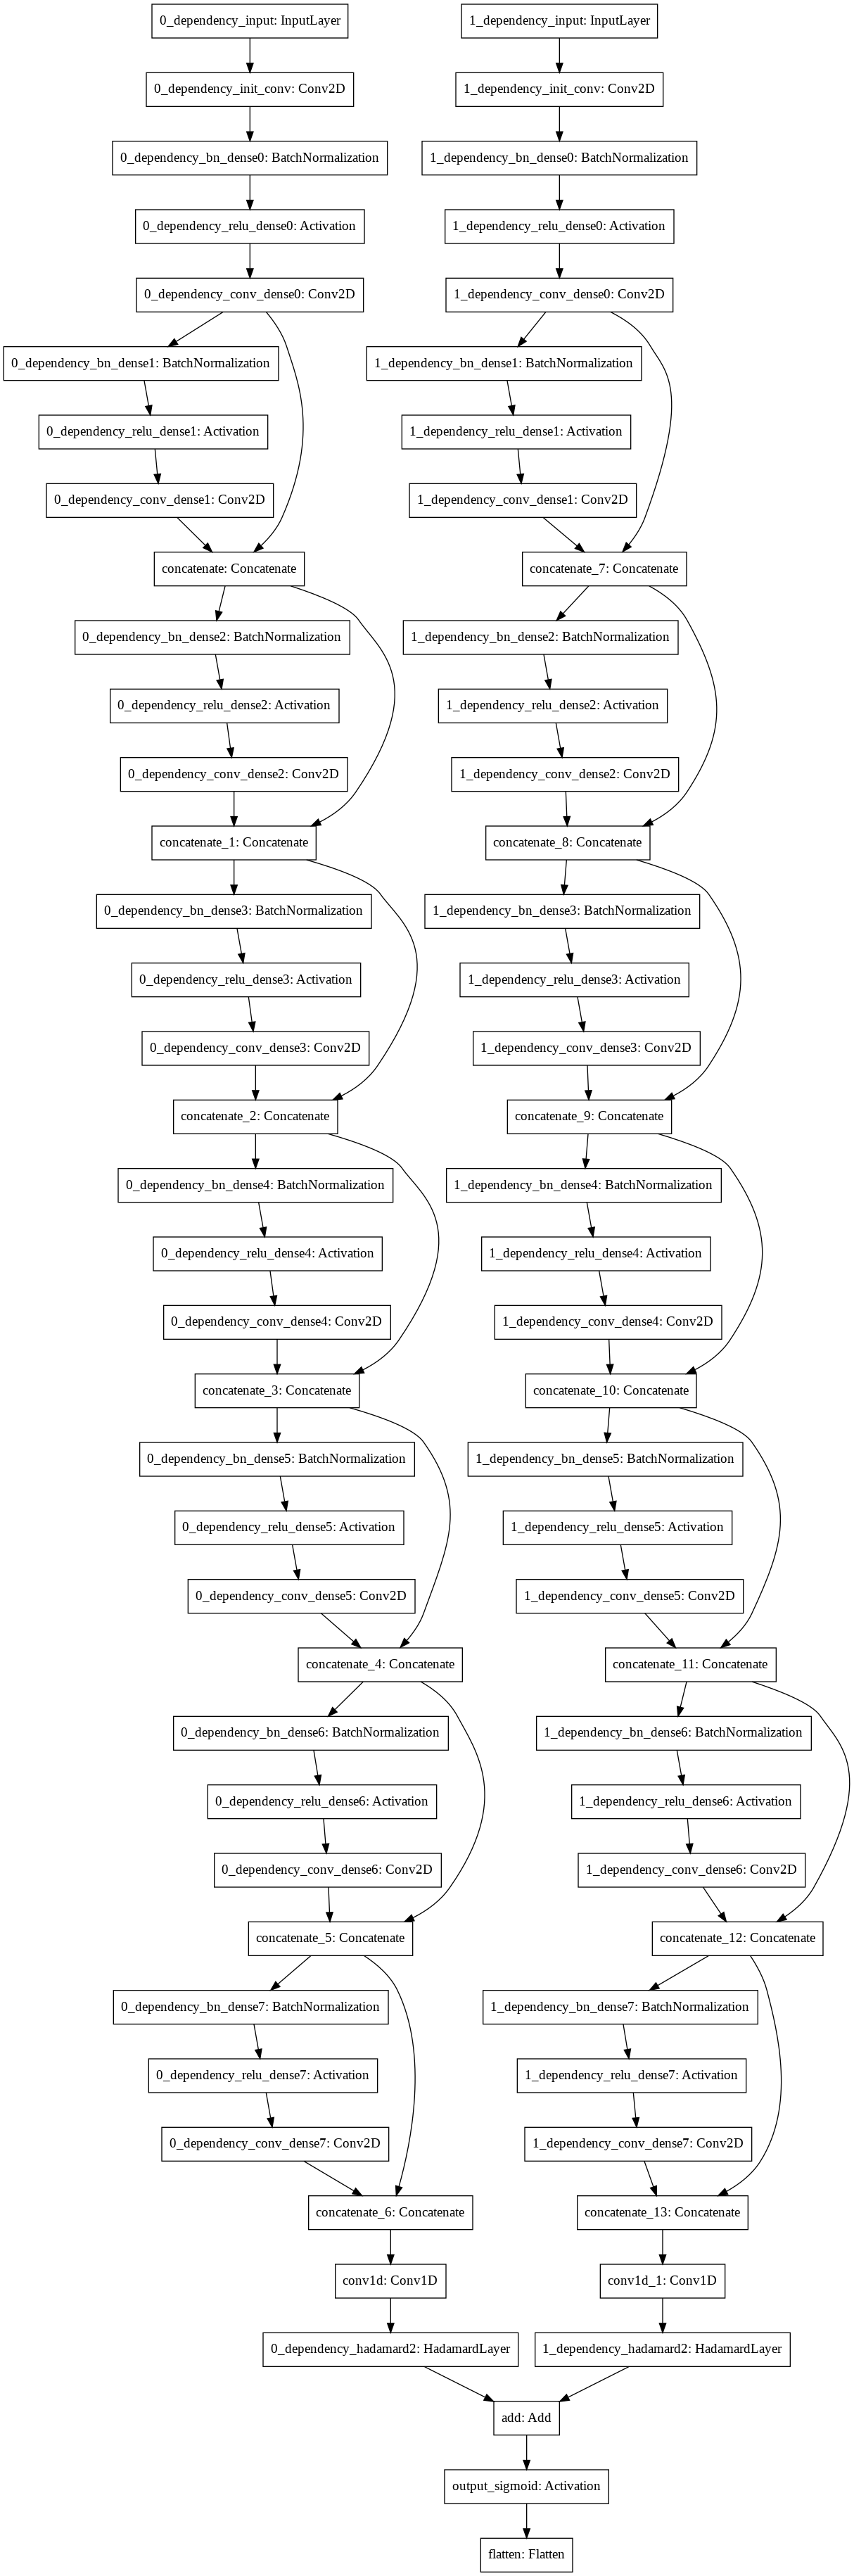

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [ ]:
from functions.postprocessing.ErrorEvaluation import calculate_errors

In [ ]:
pred = model.predict([x_closeness[:], x_period[:]])
pred, base = calculate_errors(pred, internet_origin, internet_min, internet_max, log10=False)

all:  92.36774878625508
test:  96.121798353327
val:  60.66047215528243
